In [8]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# カブトムシの死亡率に関するデータ

一般化線形モデル入門に掲載。二硫化炭素ガスに5時間暴露されたカブトムシの死亡数とガス濃度の関係性を調べる課題。

$n$匹のカブトムシのうち$y$匹が死んでしまう確率$\theta$は二項分布に従う。

$$
p(y \mid n, \theta)=\left(\begin{array}{l}
n \\ y \end{array}\right) \theta^{y}(1-\theta)^{n-y}
$$

今回はロジスティック関数で確率$theta$を作り、それに基づいて二項分布を確率モデルとして利用する。

In [3]:
data = pd.DataFrame({
    'gas':[1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.861 , 1.8839],
    'beetles':[59, 60, 62, 56, 63, 59, 62, 60],
    'deaths':[ 6, 13, 18, 28, 52, 53, 61, 60]
})

In [4]:
data.head()

,gas,beetles,deaths
0,1.6907,59,6
1,1.7242,60,13
2,1.7552,62,18
3,1.7842,56,28
4,1.8113,63,52


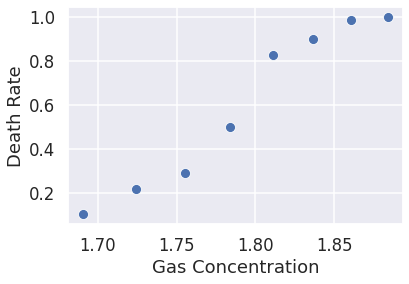

In [5]:
sns.scatterplot(x=data['gas'], y=data['deaths']/data['beetles'], s=100)

plt.xlabel('Gas Concentration')
plt.ylabel('Death Rate');

In [6]:
gas = data['gas'].values
deaths = data['deaths'].values
beetles = data['beetles'].values

gas_mu = np.mean(gas)
gas_sd = np.std(gas)

gas_scaled = (gas - gas_mu) / gas_sd

In [12]:
def model(gas_scaled=None, deaths=None, beetles=None, N=0):
    a = numpyro.sample("a", dist.Normal(0,10))
    b = numpyro.sample("b", dist.Normal(0,10))

    mu = numpyro.deterministic("mu", a*gas_scaled+b)

    theta = numpyro.deterministic("theta", jax.nn.sigmoid(mu))

    with numpyro.plate("plate_obs", N):
        numpyro.sample("obs", dist.Binomial(total_count=beetles, probs=theta), obs=deaths)

nuts = NUTS(model)
mcmc = MCMC(sampler=nuts, num_warmup=1000, num_samples=5000, num_chains=4)

mcmc.run(random.PRNGKey(1), gas_scaled=gas_scaled, deaths=deaths, beetles=beetles, N=len(beetles))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 7035.41it/s, 7 steps of size 7.18e-01. acc. prob=0.94]


In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

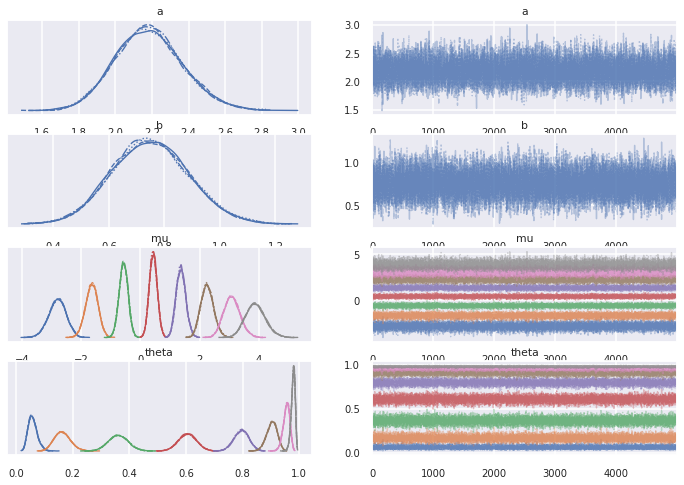

In [14]:
az.plot_trace(idata);

In [16]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.183,0.185,1.830,2.525,0.002,0.001,12005.0,11787.0,1.0
b,0.750,0.138,0.496,1.013,0.001,0.001,13366.0,12857.0,1.0
mu[0],-2.804,0.291,-3.372,-2.278,0.002,0.002,15773.0,12834.0,1.0
mu[1],-1.645,0.208,-2.047,-1.265,0.002,0.001,17897.0,13227.0,1.0
mu[2],-0.573,0.149,-0.860,-0.300,0.001,0.001,19565.0,14407.0,1.0
mu[3],0.431,0.132,0.183,0.679,0.001,0.001,15003.0,13880.0,1.0
mu[4],1.368,0.162,1.072,1.680,0.002,0.001,11472.0,10541.0,1.0
mu[5],2.254,0.215,1.852,2.658,0.002,0.001,10662.0,10426.0,1.0
mu[6],3.088,0.274,2.577,3.608,0.003,0.002,10568.0,10543.0,1.0
mu[7],3.880,0.335,3.268,4.526,0.003,0.002,10628.0,10496.0,1.0


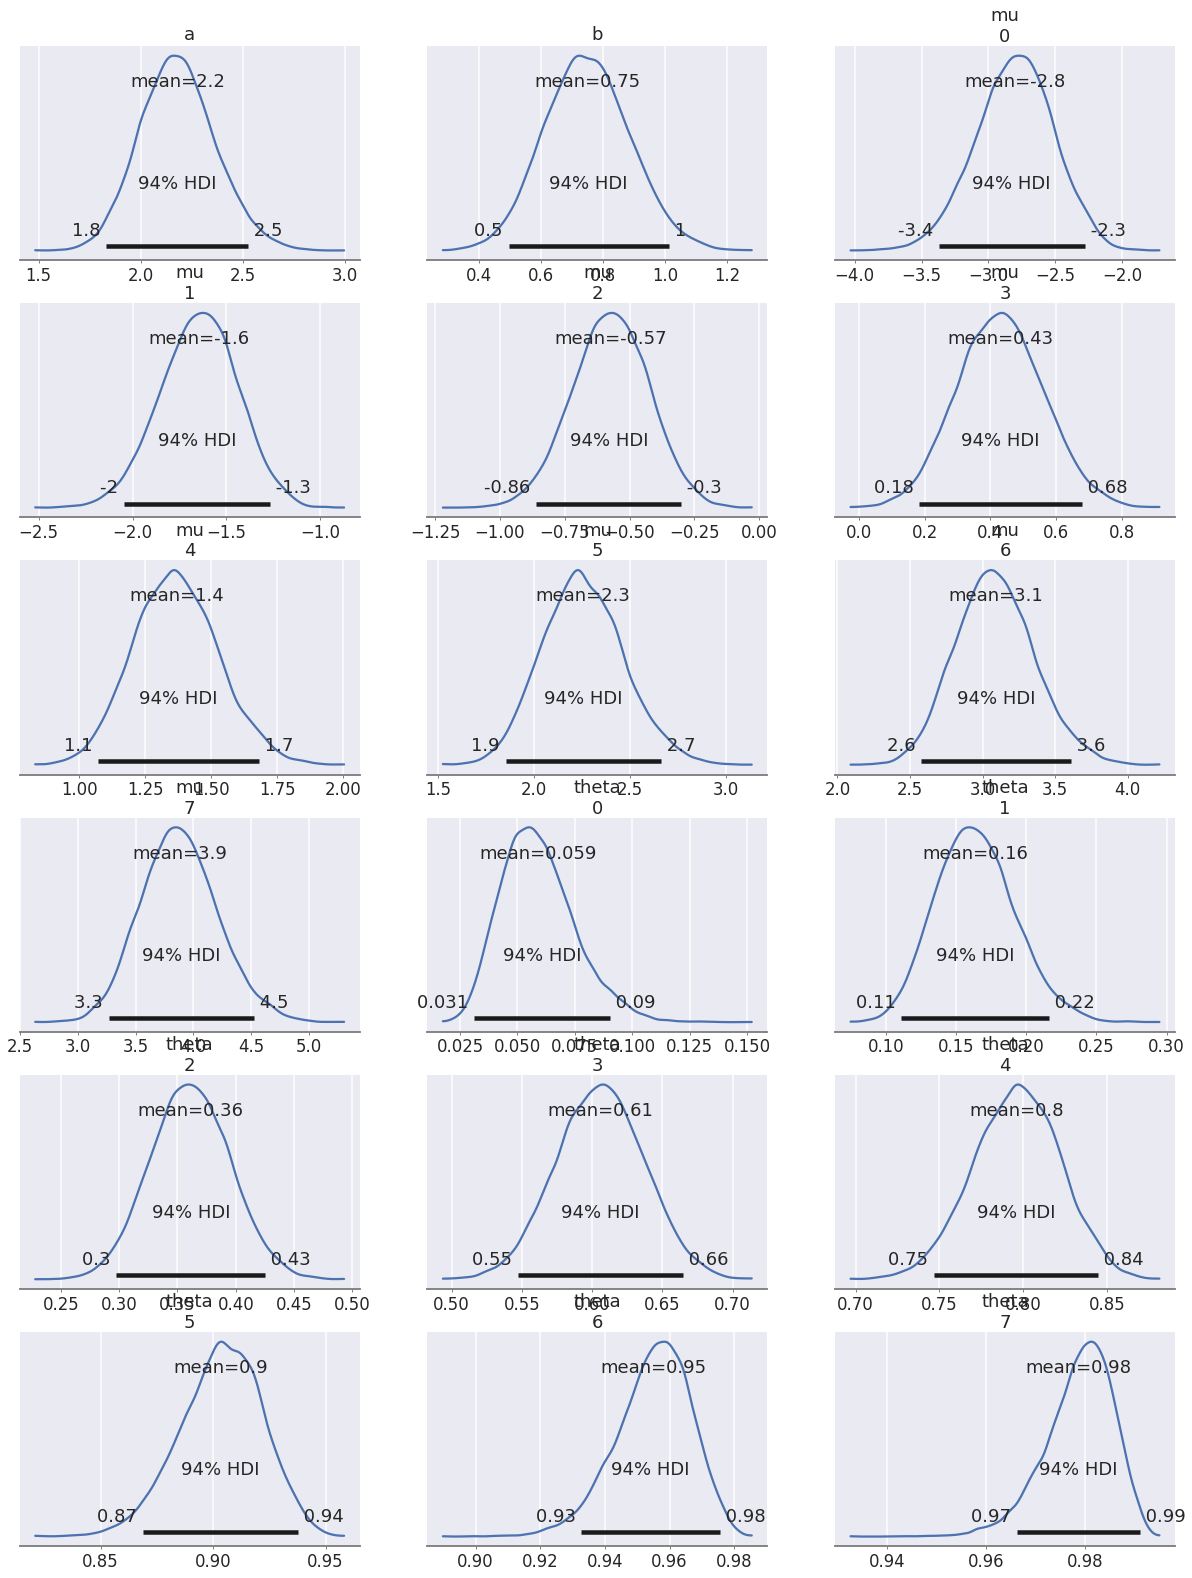

In [17]:
az.plot_posterior(idata);

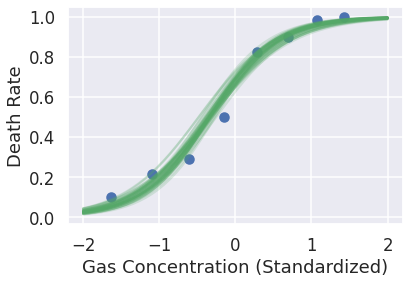

In [18]:
def plot_curves(trace):
    samples_to_plot = 50
    x_scaled_new = np.linspace(-2, 2, 50)
        
    for k in range(1, samples_to_plot):
        a_sample = trace['a'][-k]
        b_sample = trace['b'][-k]
    
        mu = a_sample * x_scaled_new + b_sample
        
        p = 1 / (1 + np.exp(-mu))
        
        plt.plot(x_scaled_new, p, c='g', alpha=0.2)

plt.scatter(gas_scaled, deaths / beetles)
plot_curves(mcmc_samples)

plt.xlabel('Gas Concentration (Standardized)')
plt.ylabel('Death Rate');

In [20]:
predictive = Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(1), gas_scaled=gas_scaled, beetles=beetles, N=len(gas_scaled))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

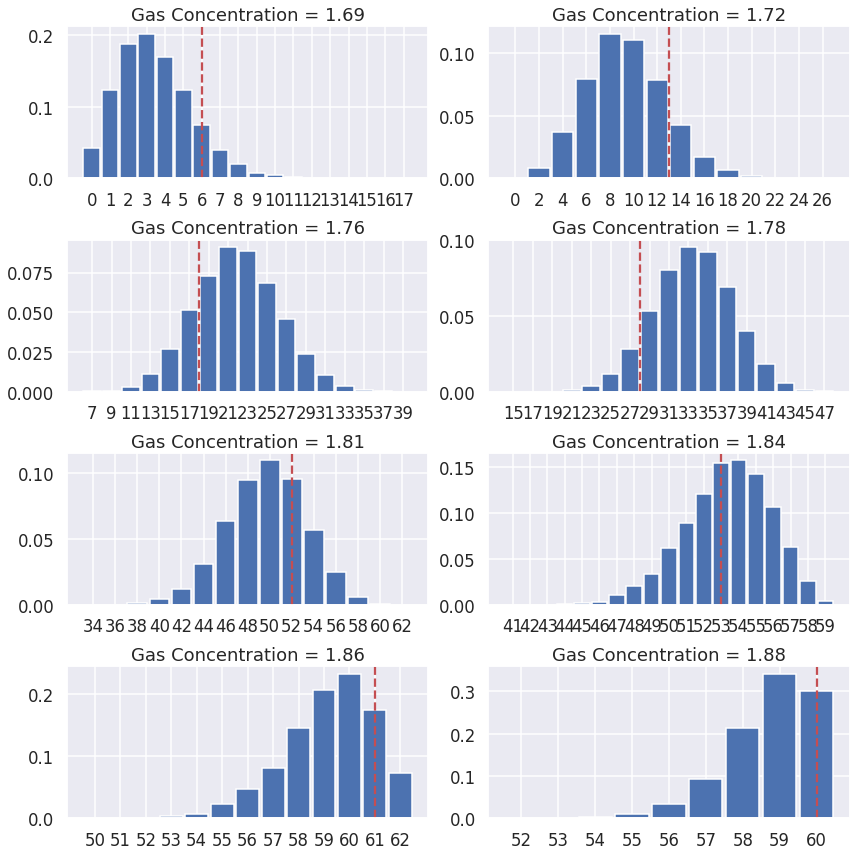

In [21]:
fig = plt.figure(figsize=(12, 12))

for k in range(8):
    
    ax = fig.add_subplot(4, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(deaths[k], color='r', linestyle='dashed')
    ax.set_title('Gas Concentration = {:.2f}'.format(gas[k]))

plt.tight_layout()